In [ ]:
import os
import sys
import hashlib

!pip install tensorflow_addons
!pip install rdkit
!pip install keras-swa
# !pip install dropconnect-tensorflow # Not currently using DropConnect

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from swa.tfkeras import SWA

from custom_loss import rwrmse, alpha_1point75, alpha_1point5, alpha_1point25, alpha_adaptive, pseudo_huber

import math as m
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem import RDKFingerprint

from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-swa: filename=keras_swa-0.1.7-py3-none-any.whl size=7824 sha256=5bd734500aa7fa6a8e252237b48da4bf48a2fa6263242fe31b1621285c048e18
  Stored in directory: /root/.cache/pip/wheels/1f/f3/68/48c5eb0509cd523f1c975e1240ae3d97540f6e2666bcdedae4
Successfully built keras-swa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Set random seeds
np.random.seed(8)
tf.random.set_seed(8)

In [ ]:
# Load training data
train_path = '/content/drive/MyDrive/Colab Notebooks/Input/singlecell/de_train.parquet'
df_train = pd.read_parquet(train_path)

In [ ]:
# Get Morgan fingerprints
df_X = np.zeros([df_train.shape[0], 2048])
for i in range(df_train.shape[0]):
	df_X[i, :] = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(df_train["SMILES"][i]), radius=2, nBits=2048))

In [ ]:
# One hot encode the cells
# One hot ordering: [B cells,  Myeloid cells,  NK cells,  T cells CD4+,  T cells CD8+,  T regulatory cells]
one_hot = np.array(pd.get_dummies(df_train["cell_type"]) * 1.0)

In [ ]:
# One hot encode controls
# 1 - control, 0 - otherwise
train_control = np.zeros([df_train.shape[0], 1])
for i, cont in enumerate(df_train["control"]):
  if cont == True:
    train_control[i] = 1.

In [ ]:
# Get dose values
df_logfc = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/logFC.parquet')
dose = np.array(df_logfc["dose_uM"])
dose = dose.reshape((df_train.shape[0], 1))

In [ ]:
# Get cell count values for cell type, drug pairs
df_n_cell = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/train_n_cells.csv')

In [ ]:
# Get log p values for train set
df_chem = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/chemical_properties.csv')
# Apply Log10 transform to n_atoms, molecular weight, and molar refractivity
df_chem["n_atoms"] = df_chem["n_atoms"].map(np.log10)
df_chem["mol_weight"] = df_chem["mol_weight"].map(np.log10)
df_chem["MR"] = df_chem["MR"].map(np.log10)

# Merge n cells onto df_chem
df_chem = df_chem.join(df_n_cell["n_cells"])

# Apply log10 transform to n_cells
df_chem["n_cells"] = df_chem["n_cells"].map(np.log10)

In [ ]:
# Scale data
scaler = StandardScaler()
scaler.fit(df_chem[["log_P", "MR"]])

StandardScaler()

In [ ]:
# Join to form training matrix
# Toggle to include dose and control
incl_control = True
if incl_control:
  one_hot = np.concatenate((one_hot, scaler.transform(df_chem[["log_P", "MR"]])), axis=1)
  one_hot = np.concatenate((one_hot, train_control), axis=1)
  x_train = np.concatenate((one_hot, df_X), axis=1)
else:
  # Normal features to be used
  one_hot = np.concatenate((one_hot, scaler.transform(df_chem[["log_P", "MR"]])), axis=1)
  x_train = np.concatenate((one_hot, df_X), axis=1)

In [ ]:
x_train.shape

(614, 2057)

In [ ]:
# Make train data and targets
n_genes = 18211
y_train = np.array(df_train.iloc[:, 5:])

In [ ]:
np.min(y_train)

-180.5192016034818

In [ ]:
np.max(y_train)

179.32417689610105

In [ ]:
x_train.shape, y_train.shape

((614, 2057), (614, 18211))

In [ ]:
# Perform dimension reduction
run_svd = True
run_autoencoder = False
if run_svd:
  U, S, VT = np.linalg.svd(y_train, full_matrices=False)
  # Calculate aspect ratio and cutoff
  Beta = y_train.shape[0] / y_train.shape[1]
  # Approximate w(B)
  w_B = 0.56 * Beta ** 3 - 0.95 * Beta ** 2 + 1.82 * Beta + 1.43
  # Higher w_B, higher tau threshold, lower number of columns kept
  w_B_low = w_B - 0.02
  w_B_high = w_B + 0.02
  med_S = np.median(S)
  tau = w_B_high * med_S
  # Optimal modes
  # Can consider dropping a few modes
  q = np.max(np.where(S > tau))
  U, S, VT = U[:, :(q+1)], np.diag(S[:(q+1)]), VT[:(q+1), :]
  q

if run_autoencoder:
  encoding_dim = 115
  # Load in AE model
  ae_target = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AE Models/sign_logpv_autoencoder_linear_embed_600e_115.h5')
  # Encoder
  encoder = keras.Model(inputs=ae_target.input, outputs=ae_target.layers[7].output)
  # Decoder
  decoder = keras.Model(inputs=ae_target.layers[8].input, outputs=ae_target.layers[-1].output)

In [ ]:
# Get embeddings
if run_svd:
  # Calculate denoised y_train
  y_train_tilde = U @ S @ VT
  # Get y_embed
  y_embed = U @ S

if run_autoencoder:
  # Get y_embed
  y_embed = encoder.predict(y_train)

y_embed.shape

(614, 114)

In [ ]:
# Keep copy of x_train in original row order wrt df_train
x_train_copy = x_train
y_train_copy = y_train
y_embed_copy = y_embed

In [ ]:
x_train.shape, y_train.shape, y_embed.shape

((614, 2057), (614, 18211), (614, 114))

In [ ]:
# Model
# Architecture selection
skip_connections = False
selu_stack = True

# Create models
def create_skip_model():
  input_size = x_train.shape[1]
  inputs_reg = layers.Input((input_size,))
  x_1 = layers.Dense(3071, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(inputs_reg)
  x_2 = layers.Dense(3071, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_1)
  concat_1 = layers.Concatenate(axis=1)([inputs_reg, x_2])
  selu_1 = layers.Activation(keras.activations.selu)(concat_1)
  x_3 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_1)
  x_4 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_3)
  add_1 = layers.Add()([selu_1, x_4])
  selu_2 = layers.Activation(keras.activations.selu)(add_1)
  x_5 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_2)
  x_6 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_5)
  add_2 = layers.Add()([selu_2, x_6])
  selu_3 = layers.Activation(keras.activations.selu)(add_2)
  x_7 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_3)
  x_8 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_7)
  add_3 = layers.Add()([selu_3, x_8])
  selu_4 = layers.Activation(keras.activations.selu)(add_3)
  if run_svd:
    output_reg = layers.Dense((q+1), kernel_initializer="glorot_normal")(selu_4)
  if run_autoencoder:
    output_reg = layers.Dense(encoding_dim, kernel_initializer="glorot_normal")(selu_4)
  model = keras.Model(inputs=inputs_reg, outputs=output_reg)
  return model

# Create SELU stack model
def create_selu_model():
  input_size = x_train.shape[1]
  inputs_reg = layers.Input((input_size,))
  x_1 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(inputs_reg)
  x_2 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_1)
  x_3 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_2)
  x_4 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_3)
  x_5 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_4)
  x_6 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_5)
  x_7 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_6)
  x_8 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_7)
  if run_svd:
    output_reg = layers.Dense((q+1), kernel_initializer="glorot_normal")(x_8)
  if run_autoencoder:
    output_reg = layers.Dense(encoding_dim, kernel_initializer="glorot_normal")(x_8)
  model = keras.Model(inputs=inputs_reg, outputs=output_reg)
  return model

In [ ]:
# SELU stack
model = create_selu_model()

In [ ]:
# Define losses
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2057)]            0         
                                                                 
 dense (Dense)               (None, 5128)              10553424  
                                                                 
 dense_1 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_2 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_3 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_4 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_5 (Dense)             (None, 5128)              263015

In [ ]:
# Stochastic weight averaging
start_epoch = 2
swa = SWA(start_epoch=start_epoch,
          lr_schedule='manual',
          verbose=1)

# Optimizer
# Best scores used learning rate 7e-5, and SWA learning rate 5e-5
learning_rate = 7e-5

# Cosine rate scheduler
# Every 7800 steps, 200 epochs. Cosine Decay changes LR each batch (step)
# Every 3900 steps, 100 epochs
cos_sched = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=learning_rate, first_decay_steps=7800, t_mul=1.0, m_mul=0.9, alpha=0.01)

# Optimisers
# Try higher weight decay for larger models
# lambda = lambda(norm) * sqrt(batch_size / (n * t)), where n is number of training points and t is number of epochs
# Try lambda(norm) between 0.025 to 0.05
weight_decay = 0.004 # Try 1e-2, 5e-2, 1e-1

opt = keras.optimizers.legacy.Adam(learning_rate=cos_sched)

opt_adamW = keras.optimizers.AdamW(learning_rate=cos_sched)

opt_adaMax = keras.optimizers.Adamax(learning_rate=cos_sched)

In [ ]:
# Compile model for deriving JTT weights
model.compile(loss=mae, optimizer=opt_adamW, metrics=[rwrmse])

# Train model # No SWA during initial train
model.fit(x=x_train, y=y_embed, epochs=200, batch_size=16, shuffle=True)

Epoch 1/200
39/39 [==============================] - 12s 81ms/step - loss: 6.0877 - rwrmse: 13.7768
Epoch 2/200
39/39 [==============================] - 3s 79ms/step - loss: 5.5213 - rwrmse: 12.9387
Epoch 3/200
39/39 [==============================] - 3s 79ms/step - loss: 5.2616 - rwrmse: 12.5580
Epoch 4/200
39/39 [==============================] - 3s 82ms/step - loss: 5.0835 - rwrmse: 12.2772
Epoch 5/200
39/39 [==============================] - 3s 82ms/step - loss: 4.8293 - rwrmse: 11.9087
Epoch 6/200
39/39 [==============================] - 3s 79ms/step - loss: 4.5937 - rwrmse: 11.4577
Epoch 7/200
39/39 [==============================] - 3s 79ms/step - loss: 4.4468 - rwrmse: 11.1345
Epoch 8/200
39/39 [==============================] - 3s 79ms/step - loss: 4.2960 - rwrmse: 10.7737
Epoch 9/200
39/39 [==============================] - 3s 82ms/step - loss: 4.2793 - rwrmse: 10.6945
Epoch 10/200
39/39 [==============================] - 3s 80ms/step - loss: 4.0442 - rwrmse: 10.2147
Epoch 11

In [ ]:
# Define row-wise MSE
def row_rmse(y_true, y_pred):
  return np.mean((y_true - y_pred) ** 2, axis=1)

def row_mae(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred), axis=1)

In [ ]:
# Inference on original un-permuted train
y_train_pred = model.predict(x_train)

# Get error for each sample in original x_train
err = row_mae(y_embed, y_train_pred)

K.eval(rwrmse(y_embed, y_train_pred))

20/20 [==============================] - 0s 8ms/step


0.045177281561253224

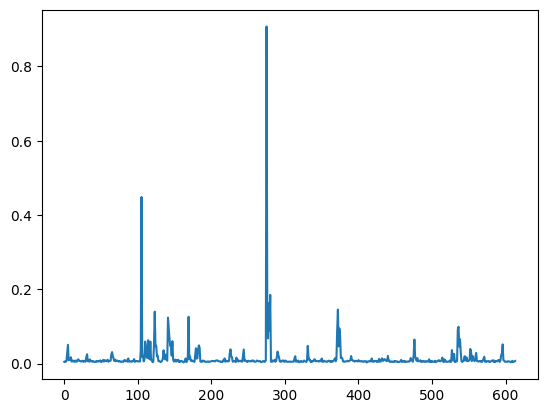

In [ ]:
# Plot error
plt.plot(err)
plt.show()

In [ ]:
# Calculate median error
err_med = np.median(err)
err_mean = np.mean(err)
err_std = np.std(err)

err_med, err_mean, err_std

(0.006696024296036299, 0.014775920631545186, 0.04476429744003106)

In [ ]:
# Define cutoff for indices to resample
cutoff = 3 * err_med

In [ ]:
# Get index of samples which have error above cutoff and which are not control observations
idx_list = np.where((err > cutoff) & (x_train[:, 8] == 0))[0]

In [ ]:
len(idx_list)

60

In [ ]:
# 3x median error (from MAE regression)
idx_list = [  4,   5,  31,  64,  65, 110, 111, 114, 115, 117, 122, 123, 124,
       125, 127, 135, 138, 141, 142, 143, 144, 145, 146, 147, 169, 178,
       179, 182, 183, 184, 225, 226, 243, 244, 290, 291, 331, 371, 372,
       373, 374, 375, 390, 440, 475, 476, 527, 530, 535, 536, 537, 538,
       539, 552, 553, 555, 560, 594, 595, 596]

In [ ]:
# Mean error list
idx_list = np.where((err > err_mean) & (x_train[:, 8] == 0))[0]

In [ ]:
# 1x mean error (from MAE regression)
idx_list = [  4,   5,   9,  30,  31,  64,  65,  66, 110, 111, 112, 113, 114,
       115, 117, 122, 123, 124, 125, 126, 127, 135, 138, 141, 142, 143,
       144, 145, 146, 147, 168, 169, 171, 178, 179, 182, 183, 184, 225,
       226, 227, 228, 234, 243, 244, 289, 290, 291, 292, 314, 331, 332,
       371, 372, 373, 374, 375, 376, 377, 390, 440, 471, 475, 476, 477,
       514, 527, 528, 530, 535, 536, 537, 538, 539, 544, 545, 547, 552,
       553, 555, 559, 560, 571, 594, 595, 596]

In [ ]:
# Sign regression index list 75% accuracy (from sign regression JTT)
idx_list = [  8,   9,  10,  11,  12,  30,  31,  32,  33,  34,  38,  40,  56,
        72,  73,  74,  75,  76,  86,  87,  90,  91,  94,  95,  96,  97,
       118, 130, 151, 154, 155, 156, 157, 158, 168, 169, 170, 171, 174,
       193, 194, 201, 202, 223, 229, 230, 233, 234, 235, 236, 267, 268,
       271, 272, 297, 309, 313, 315, 316, 317, 327, 336, 377, 381, 382,
       405, 409, 410, 411, 412, 413, 414, 419, 447, 448, 451, 452, 456,
       459, 460, 467, 475, 477, 478, 517, 518, 519, 520, 521, 523, 540,
       541, 556, 557, 558, 559, 579, 602, 603, 607]

In [ ]:
# Sign regression index list (< 0.2 p-vals, error - 3 x err_std)
idx_list = [  8,   9,  10,  11,  12,  14,  23,  25,  28,  29,  34,  38,  41,
        44,  52,  56,  60,  63,  72,  73,  74,  75,  76,  77,  84,  86,
        87,  89,  90,  91,  93,  94,  95,  96,  97,  99, 118, 119, 120,
       121, 126, 127, 130, 131, 154, 155, 156, 157, 158, 168, 169, 174,
       175, 177, 187, 193, 194, 196, 198, 201, 202, 214, 215, 222, 223,
       224, 229, 230, 232, 233, 234, 235, 236, 239, 240, 267, 268, 271,
       272, 287, 295, 297, 300, 303, 305, 306, 307, 310, 315, 316, 317,
       320, 321, 323, 324, 335, 336, 338, 342, 355, 356, 357, 358, 365,
       377, 379, 380, 381, 382, 393, 395, 405, 407, 409, 410, 411, 412,
       413, 414, 419, 424, 444, 447, 448, 449, 450, 451, 452, 453, 455,
       456, 459, 460, 464, 467, 468, 470, 474, 477, 483, 503, 517, 518,
       519, 520, 521, 522, 523, 540, 541, 543, 546, 548, 556, 557, 563,
       567, 578, 579, 581, 587, 602, 603, 605, 606, 607, 608, 611]

In [ ]:
len(idx_list)

100

In [ ]:
# Get samples which had large error in train to upsample from
x_train_upsample = x_train[idx_list, :]
y_embed_upsample = y_embed[idx_list, :]

x_train_upsample.shape, y_embed_upsample.shape

((100, 2057), (100, 114))

In [ ]:
# Generate new samples
scaling_factor = 7
new_samples_x = x_train_upsample
new_samples_y_embed = y_embed_upsample

for i in range(1, scaling_factor, 1):
  new_samples_x = np.concatenate((new_samples_x, x_train_upsample), axis=0)
  new_samples_y_embed = np.concatenate((new_samples_y_embed, y_embed_upsample), axis=0)

new_samples_x.shape, new_samples_y_embed.shape

((600, 2057), (600, 114))

In [ ]:
# Concatenate results to original x_train and y_embed
x_train = np.concatenate((x_train, new_samples_x), axis=0)
y_embed = np.concatenate((y_embed, new_samples_y_embed), axis=0)

In [ ]:
x_train.shape, y_embed.shape

((1214, 2057), (1214, 114))

In [ ]:
# Permute data for final train
permuted_indices = np.random.permutation(np.arange(x_train.shape[0]))
x_train = x_train[permuted_indices, :]
y_embed = y_embed[permuted_indices, :]

In [ ]:
# Create new model for training
# Skip connections model

if skip_connections:
  model = create_skip_model()

# SELU stack
if selu_stack:
  model = create_selu_model()

In [ ]:
# Define losses
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2057)]            0         
                                                                 
 dense (Dense)               (None, 5128)              10553424  
                                                                 
 dense_1 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_2 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_3 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_4 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_5 (Dense)             (None, 5128)              263015

In [ ]:
# Stochastic weight averaging
start_epoch = 2
swa = SWA(start_epoch=start_epoch,
          lr_schedule='manual',
          verbose=1)

# Optimizer
# Best scores used learning rate 7e-5, and SWA learning rate 5e-5
learning_rate = 7e-5 # 7e-5 learning rate for batch size 16, 7e-5 learning rate for batch size 8

# Cosine rate scheduler
# Every 7800 steps, 200 epochs. Cosine Decay changes LR each batch (step)
# Every 3900 steps, 100 epochs
# 47 x 200 epochs = 9400 steps
cos_sched = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=learning_rate, first_decay_steps=15200, t_mul=1.0, m_mul=0.9, alpha=0.01)

# Optimisers
# Try higher weight decay for larger models
# lambda = lambda(norm) * sqrt(batch_size / (n * t)), where n is number of training points and t is number of epochs
# Try lambda(norm) between 0.025 to 0.05
weight_decay = 0.004 # Try 1e-2, 5e-2, 1e-1

opt = keras.optimizers.legacy.Adam(learning_rate=cos_sched)

opt_adamW = keras.optimizers.AdamW(learning_rate=cos_sched)

opt_adaMax = keras.optimizers.Adamax(learning_rate=cos_sched, weight_decay=weight_decay)

In [ ]:
# Compile model for training
model.compile(loss=mae, optimizer=opt_adamW, metrics=[rwrmse])

# Train model with JTT upsampling
model.fit(x=x_train, y=y_embed, epochs=800, batch_size=16, callbacks=[swa], shuffle=True)

Epoch 1/800
 6/76 [=>............................] - ETA: 5s - loss: 5.4018 - rwrmse: 11.2614

76/76 [==============================] - 18s 78ms/step - loss: 4.7718 - rwrmse: 9.5394

Epoch 00002: starting stochastic weight averaging
Epoch 2/800
76/76 [==============================] - 7s 97ms/step - loss: 4.0540 - rwrmse: 8.5310
Epoch 3/800
76/76 [==============================] - 7s 94ms/step - loss: 3.6732 - rwrmse: 7.9200
Epoch 4/800
76/76 [==============================] - 7s 96ms/step - loss: 3.3458 - rwrmse: 7.4199
Epoch 5/800
76/76 [==============================] - 7s 94ms/step - loss: 3.1734 - rwrmse: 7.1041
Epoch 6/800
76/76 [==============================] - 7s 96ms/step - loss: 2.8101 - rwrmse: 6.5168
Epoch 7/800
76/76 [==============================] - 7s 95ms/step - loss: 2.8034 - rwrmse: 6.4292
Epoch 8/800
76/76 [==============================] - 7s 96ms/step - loss: 2.5362 - rwrmse: 5.9698
Epoch 9/800
76/76 [==============================] - 7s 95ms/step - loss: 2.4417 - rwrmse: 5.7546
Epoch 10/800
76/76 [==============================] - 7s 97ms/step - loss: 2.3

In [ ]:
incl_control

True

In [ ]:
# Load in submission set
df_id = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/id_map_submission.csv')

# Convert to Morgan fingerprints
df_X = np.zeros([df_id.shape[0], 2048])
for i in range(df_id.shape[0]):
	df_X[i, :] = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(df_id["SMILES"][i]), radius=2, nBits=2048))

# One hot encode the cell types
n_cell_types = 6
cells = ["B cells", "Myeloid cells", "NK cells", "T cells CD4+", "T cells CD8+", "T regulatory cells"]
one_hot = pd.DataFrame(np.zeros([df_id.shape[0], n_cell_types]), columns=cells)

# Fill in one_hot
one_hot_test = pd.get_dummies(df_id["cell_type"]) * 1.0
one_hot["B cells"] = one_hot_test["B cells"]
one_hot["Myeloid cells"] = one_hot_test["Myeloid cells"]
one_hot = np.array(one_hot)

# Control and dose for test
# Control (1 - control, 0 - non-control)
test_control = np.zeros([df_id.shape[0], 1])
# Dose (1 uM for all compounds)
test_dose = np.ones((df_id.shape[0], 1))

# Log10 transform n_atoms, molecular weight, and molar refractivity
df_id["n_atoms"] = df_id["n_atoms"].map(np.log10)
df_id["mol_weight"] = df_id["mol_weight"].map(np.log10)
df_id["MR"] = df_id["MR"].map(np.log10)

# Merge to construct test matrix
if incl_control:
	# Test matrix if controls and dose used
	one_hot = np.concatenate((one_hot, scaler.transform(df_id[["log_P", "MR"]])), axis=1)
	one_hot = np.concatenate((one_hot, test_control), axis=1)
	x_test = np.concatenate((one_hot, df_X), axis=1)
else:
	# Test matrix if controls / dose not used
	one_hot = np.concatenate((one_hot, scaler.transform(df_id[["log_P", "MR"]])), axis=1)
	x_test = np.concatenate((one_hot, df_X), axis=1)

del one_hot, one_hot_test

In [ ]:
x_test.shape

(255, 2057)

In [ ]:
# Predict
output_emb = model.predict(x_test)

if run_svd:
  output_high = output_emb @ VT
if run_autoencoder:
  output_high = decoder.predict(output_emb)

# Read in submission file
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/sample_submission.csv')
submission.iloc[:, 1:] = output_high

8/8 [==============================] - 0s 9ms/step


In [ ]:
np.max(output_emb), np.min(output_emb)

(146.04398, -937.3584)

In [ ]:
np.max(output_high), np.min(output_high)

(60.73195955503297, -26.16313532779944)

In [ ]:
# Save as submission
# Generate truncated SHA256 hash
truncated_hash = hashlib.sha256(os.urandom(23)).hexdigest()[:23]

submission_path = '/content/drive/MyDrive/Colab Notebooks/Output/ecfp_reg_8lselu_stack_JTT_v255_' + truncated_hash + '.csv'
submission.to_csv(submission_path, index=False)

# Print hash
print(truncated_hash)

7ad21c176b8679447c2d168


In [ ]:
# Calculuate rwrmse for original y_train
if run_svd:
  y_train_pred = model.predict(x_train_copy) @ VT
if run_autoencoder:
  y_train_pred = decoder.predict(model.predict(x_train_copy))

train_loss = K.eval(rwrmse(y_train_copy, y_train_pred))
train_loss

20/20 [==============================] - 0s 8ms/step


0.5339867635901508

In [ ]:
# Save predictions on train
filepath = '/content/drive/MyDrive/Colab Notebooks/Train Predictions/train_predictions_' + 'v255_' + truncated_hash + '.csv'
y_train_pred = pd.DataFrame(y_train_pred)

# Save as csv
y_train_pred.to_csv(filepath, index=False)

In [ ]:
# Save model
# Use .keras extension to save whole model
filepath = '/content/drive/MyDrive/Colab Notebooks/Models/ecfp_reg_8lselu_stack_v255_' + truncated_hash + '.keras'
model.save(filepath)